# Test `separable_conv2d`, `depthwise_conv2d`, `pointwise_conv2d` (`Latency`, `io_parallel`)

Please test it with the [sepconv-latency-ioparallel](https://github.com/fastmachinelearning/hls4ml/tree/sepconv-latency-ioparallel) branch.

## Libraries

In [1]:
#
# Choose the layer to test
#
#LAYER = 'depthwise_conv2d' # 
#LAYER = 'pointwise_conv2d'
LAYER = 'separable_conv2d' # uses both depthwise and pointwise

RUN_HLS = True
IO_TYPE = 'io_parallel'
STRATEGY = 'Latency'
BACKEND = 'Vivado'

H = 5    # Input height
W = 6    # Input width
Din = 1  # Input # of channels
Fh = 3   # Kernel height
Fw = 3   # Kernel width
Dout = 2 # Kernel # of filters

B = 1   # Test set batch size

FXD_W = 12 # Fixed-point precision, word bit width
FXD_I = 11 # Fixed-point precision, integer-part bit width

In [2]:
# Disable some console warnings on the ASIC-group servers
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
os.environ['PATH'] = '/home/xilinx/Vivado/2019.1/bin:' + os.environ['PATH'] 

In [4]:
os.environ['PATH']

'/home/xilinx/Vivado/2019.1/bin:/home/users/russelld/micromamba/envs/sepConv2d/bin:/home/users/russelld/micromamba/condabin:/home/users/russelld/.vscode-server/bin/b3e4e68a0bc097f0ae7907b217c1119af9e03435/bin/remote-cli:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/opt/puppetlabs/bin'

In [5]:
#os.environ['XILINX_VIVADO']

In [6]:
#os.environ['XILINX_VIVADO']

In [7]:
#!ls /home/xilinx/Vivado/2021.2/bin

In [8]:
!pip install PyYAML

In [9]:
#import matplotlib.pyplot as plt
#import pyaml

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

from tensorflow import keras
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential

from qkeras import *

## Keras

### Create keras model

In [10]:
def CreateModel(layer, input_shape, kernel_size, filters):
    # # Generate the same random values
    # import random
    # import numpy as np
    # import tensorflow as tf

    # random.seed(42)
    # np.random.seed(42)
    # tf.random.set_seed(42)

    x_in = Input(input_shape, name='input_1')
    if layer == 'depthwise_conv2d':
        x_out = DepthwiseConv2D(
            kernel_size=kernel_size,
            use_bias=False,
            depthwise_initializer=tf.keras.initializers.Ones(), # makes debugging easy
            bias_initializer=tf.keras.initializers.Zeros(), # makes debugging easy
            name='depthwise_conv2d'
        )(x_in)
    elif layer == 'pointwise_conv2d':
        x_out = Conv2D(
            filters=filters,
            kernel_size=(1,1),
            use_bias=False,
            kernel_initializer=tf.keras.initializers.Ones(), # makes debugging easy
            bias_initializer=tf.keras.initializers.Zeros(), # makes debugging easy
            name='pointwise_conv2d'
        )(x_in)
    else:
        x_out = SeparableConv2D(
            filters=filters,
            kernel_size=kernel_size,
            use_bias=False,
            depthwise_initializer=tf.keras.initializers.Ones(), # makes debugging easy
            pointwise_initializer=tf.keras.initializers.Ones(), # makes debugging easy
            name = 'separable_conv2d'
    )(x_in)
    model = Model(inputs=x_in, outputs=x_out)
    return model

In [11]:
model = CreateModel(LAYER, input_shape=(H,W,Din), kernel_size=(Fh, Fw), filters=Dout)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 6, 1)]         0         
                                                                 
 separable_conv2d (Separable  (None, 3, 4, 2)          11        
 Conv2D)                                                         
                                                                 
Total params: 11
Trainable params: 11
Non-trainable params: 0
_________________________________________________________________


### Show keras weights

In [12]:
# Backup print options
bkp_threshold = np.get_printoptions()['threshold']
bkp_linewidth = np.get_printoptions()['linewidth']

# Set print options
np.set_printoptions(threshold=np.inf, linewidth=np.inf)

weights = model.get_weights()
for i, w in enumerate(weights):
    print(f"Weights {i}:")
    print(w.shape)
    print(w.flatten())
    print("-----------")

# Restore print options
np.set_printoptions(threshold=bkp_threshold, linewidth=bkp_linewidth)

Weights 0:
(3, 3, 1, 1)
[1. 1. 1. 1. 1. 1. 1. 1. 1.]
-----------
Weights 1:
(1, 1, 1, 2)
[1. 1.]
-----------


### Show keras model

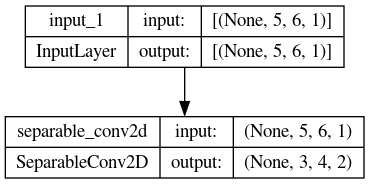

In [13]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='keras_model.png', show_shapes=True, show_layer_names=True, expand_nested=True)#, show_layer_activations=True)

### Run keras model

In [14]:
# Set a seed to have the same input traces on every run
np.random.seed(42)

toy_data = np.random.rand(B,
                          H,
                          W,
                          Din)

for i in range(B):
    for h in range(H):
        for w in range(W):
            for d in range(Din):
                toy_data[i][h][w][d] = h + w + d

In [15]:
# Show inputs
print(toy_data)

[[[[0.]
   [1.]
   [2.]
   [3.]
   [4.]
   [5.]]

  [[1.]
   [2.]
   [3.]
   [4.]
   [5.]
   [6.]]

  [[2.]
   [3.]
   [4.]
   [5.]
   [6.]
   [7.]]

  [[3.]
   [4.]
   [5.]
   [6.]
   [7.]
   [8.]]

  [[4.]
   [5.]
   [6.]
   [7.]
   [8.]
   [9.]]]]


In [16]:
# !pip install numpy --upgrade

In [17]:
# !pip install matplotlib

In [18]:
# import hls4ml.model.profiling

In [19]:
# Run tracing on a portion of the test set for the Keras model (floating-point precision)
# keras_trace = hls4ml.model.profiling.get_ymodel_keras(model, toy_data)

### Show keras traces

In [20]:
# # Backup print options
# bkp_threshold = np.get_printoptions()['threshold']
# bkp_linewidth = np.get_printoptions()['linewidth']

# # Set print options
# np.set_printoptions(threshold=np.inf, linewidth=np.inf)

# print('-------')
# print('input shape', toy_data.shape)
# print('input', toy_data.flatten())

# layer_names = [layer.name for layer in model.layers if not isinstance(layer, InputLayer)]
# for layer in layer_names:
#     print('-------')
#     print('{} shape'.format(layer), keras_trace[layer].shape)
#     print(layer, keras_trace[layer].flatten())

# print('-------')

# # Restore print options
# np.set_printoptions(threshold=bkp_threshold, linewidth=bkp_linewidth)

## QKeras

### Create qkeras model

In [21]:
def CreateQModel(type, input_shape, kernel_size, filters):
    # # Generate the same random values
    # import random
    # import numpy as np
    # import tensorflow as tf

    # random.seed(42)
    # np.random.seed(42)
    # tf.random.set_seed(42)
    
    x_in = Input(input_shape, name='q_input_1')
    if type == 'depthwise_conv2d':
        x_out = QDepthwiseConv2D(
            kernel_size=kernel_size,
            use_bias=False,
            depthwise_initializer=tf.keras.initializers.Ones(), # makes debugging easy
            depthwise_quantizer=quantized_bits(FXD_W, FXD_I-1, 1, alpha=1),
            bias_quantizer=quantized_bits(FXD_W, FXD_I-1, 1, alpha=1),
            name='q_depthwise_conv2d'
        )(x_in)
    elif type == 'pointwise_conv2d':
        x_out = QConv2D(
            kernel_size=(1,1), # 1x1 convolution
            filters=filters,
            use_bias=False,
            kernel_initializer=tf.keras.initializers.Ones(), # makes debugging easy
            kernel_quantizer=quantized_bits(FXD_W, FXD_I-1, 1, alpha=1),
            bias_quantizer=quantized_bits(FXD_W, FXD_I-1, 1, alpha=1),
            name='q_pointwise_conv2d'
        )(x_in)
    else:
        x_out = QSeparableConv2D(
            filters=filters,
            kernel_size=kernel_size,
            use_bias=False,
            depthwise_initializer=tf.keras.initializers.Ones(), # makes debugging easy
            pointwise_initializer=tf.keras.initializers.Ones(), # makes debugging easy
            depthwise_quantizer=quantized_bits(FXD_W, FXD_I-1, 1, alpha=1),
            pointwise_quantizer=quantized_bits(FXD_W, FXD_I-1, 1, alpha=1),
            bias_quantizer=quantized_bits(FXD_W, FXD_I-1, 1, alpha=1),
            name='q_separable_conv2d'
        )(x_in)
    
    model = Model(inputs=x_in, outputs=x_out)
    return model

In [22]:
qmodel = CreateQModel(LAYER, input_shape=(H,W,Din), kernel_size=(Fh, Fw), filters=Dout)
qmodel.summary()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 q_input_1 (InputLayer)      [(None, 5, 6, 1)]         0         
                                                                 
 q_separable_conv2d (QSepara  (None, 3, 4, 2)          11        
 bleConv2D)                                                      
                                                                 
Total params: 11
Trainable params: 11
Non-trainable params: 0
_________________________________________________________________


### Show qkeras weights

In [23]:
# Print the weights on console
#N_WEIGHTS = 10

# Backup print options
bkp_threshold = np.get_printoptions()['threshold']
bkp_linewidth = np.get_printoptions()['linewidth']

# Set print options
np.set_printoptions(threshold=np.inf, linewidth=np.inf)

qweights = qmodel.get_weights()
for i, w in enumerate(qweights):
    print(f"Weights {i}:")
    print(w.shape)
    #print(w)
    print(w.flatten())
    print("-----------")

# Restore print options
np.set_printoptions(threshold=bkp_threshold, linewidth=bkp_linewidth)

Weights 0:
(3, 3, 1, 1)
[1. 1. 1. 1. 1. 1. 1. 1. 1.]
-----------
Weights 1:
(1, 1, 1, 2)
[1. 1.]
-----------


### Show qkeras model

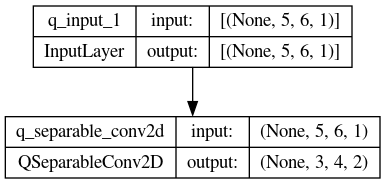

In [24]:
from tensorflow.keras.utils import plot_model
plot_model(qmodel, to_file='qkeras_model.png', show_shapes=True, show_layer_names=True, expand_nested=True)#, show_layer_activations=True)
#import hls4ml
#hls4ml.utils.plot.plot_model(qmodel, show_layer_names=True, show_precision=False, show_shapes=True, to_file='qkeras_model.png')

In [25]:
print_qstats(qmodel)

Instructions for updating:
Use ref() instead.


Instructions for updating:
Use ref() instead.



Number of operations in model:
    q_separable_conv2d            : 132   (smult_12_8)

Number of operation types in model:
    smult_12_8                    : 132

Weight profiling:
    q_separable_conv2d_weights_0   : 9     (12-bit unit)
    q_separable_conv2d_weights_1   : 2     (12-bit unit)
    q_separable_conv2d_bias        : 0     (12-bit unit)

Weight sparsity:
... quantizing model
    q_separable_conv2d             : 0.0000
    ----------------------------------------
    Total Sparsity                 : 0.0000


## hls4ml

### Configure hls4ml model

In [26]:
import hls4ml.utils
import hls4ml.converters

WARN: Unable to import optimizer(s) from expr_templates.py: No module named 'sympy'


/home/users/russelld/SepConv2D_hls4ml/hls4ml/hls4ml/converters/__init__.py:27: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)


In [27]:
config = hls4ml.utils.config_from_keras_model(
    qmodel, 
    granularity='name',
    default_precision='fixed<{},{}>'.format(FXD_W, FXD_I)
)
config['LayerName']['q_input_1']['Precision']['result'] = 'fixed<{},{}>'.format(FXD_W, FXD_I)

config['Model']['Strategy'] = STRATEGY
#config['Model']['Strategy'] = 'Resource'

hls_model = hls4ml.converters.convert_from_keras_model(
    qmodel, 
    hls_config=config, 
    output_dir='{}_{}_{}_{}_notrace_hls4ml_prj'.format(BACKEND.lower(), LAYER.lower(), STRATEGY.lower(), IO_TYPE.lower()), 
    part='xcu250-figd2104-2L-e',
    backend=BACKEND,
    io_type=IO_TYPE
)

hls_model.compile()

Interpreting Model
Topology:
Layer name: q_input_1, layer type: InputLayer, input shapes: [[None, 5, 6, 1]], output shape: [None, 5, 6, 1]
Layer name: q_separable_conv2d, layer type: QSeparableConv2D, input shapes: [[None, 5, 6, 1]], output shape: [None, 3, 4, 2]
Interpreting Model
Topology:
Layer name: q_input_1, layer type: InputLayer, input shapes: [[None, 5, 6, 1]], output shape: [None, 5, 6, 1]
Layer name: q_separable_conv2d, layer type: QSeparableConv2D, input shapes: [[None, 5, 6, 1]], output shape: [None, 3, 4, 2]
Creating HLS model
Writing HLS project


Done


In [28]:
# print(pyaml.dump(config))

### Run qkeras and hls4ml simulation

In [29]:
# Set a seed to have the same input traces on every run
np.random.seed(42)

toy_data = np.random.rand(B,H,W,Din)

for i in range(B):
    for h in range(H):
        for w in range(W):
            for d in range(Din):
                toy_data[i][h][w][d] = h + w + d

q_toy_data = quantized_bits(FXD_W, FXD_I-1, alpha=1)(toy_data).numpy()

# Enable tracing for all of the layers
for layer in config['LayerName'].keys():
    print('Enable tracing for layer:', layer)
    config['LayerName'][layer]['Trace'] = True

hmodel = hls4ml.converters.convert_from_keras_model(
    qmodel,
    hls_config=config,
    output_dir='{}_{}_{}_{}_trace_hls4ml_prj'.format(BACKEND.lower(), LAYER.lower(), STRATEGY.lower(), IO_TYPE.lower()),
    part='xcu250-figd2104-2L-e',
    io_type=IO_TYPE,
)
hmodel.compile()

# Run tracing on the test set for the hls4ml model (fixed-point precision) 
#hls4ml_pred, hls4ml_trace = hmodel.trace(q_toy_data)

# Run tracing on a portion of the test set for the Keras model (floating-point precision)
#keras_trace = hls4ml.model.profiling.get_ymodel_keras(qmodel, q_toy_data)

Enable tracing for layer: q_input_1
Enable tracing for layer: q_separable_conv2d
Enable tracing for layer: q_separable_conv2d_linear
Interpreting Model
Topology:
Layer name: q_input_1, layer type: InputLayer, input shapes: [[None, 5, 6, 1]], output shape: [None, 5, 6, 1]
Layer name: q_separable_conv2d, layer type: QSeparableConv2D, input shapes: [[None, 5, 6, 1]], output shape: [None, 3, 4, 2]
Creating HLS model
Writing HLS project


Done


In [30]:
'{}_{}_{}_{}_trace_hls4ml_prj'.format(BACKEND.lower(), LAYER.lower(), STRATEGY.lower(), IO_TYPE.lower())

'vivado_separable_conv2d_latency_io_parallel_trace_hls4ml_prj'

In [31]:
#print(keras_trace)

In [32]:
# # Save inputs and expected outputs for further debugging
# with open('{}_{}_{}_{}_trace_hls4ml_prj/tb_data/tb_input_features.dat'.format(BACKEND.lower(), LAYER.lower(), STRATEGY.lower(), IO_TYPE.lower()), 'w') as f:
#     f.write(' '.join(map(str, toy_data[0].flatten())))
# with open('{}_{}_{}_{}_trace_hls4ml_prj/tb_data/tb_output_predictions.dat'.format(BACKEND.lower(), LAYER.lower(), STRATEGY.lower(), IO_TYPE.lower()), 'w') as f:
#     f.write(' '.join(map(str, keras_trace['q_{}'.format(LAYER)][0].flatten())))

### Show qkeras and hls4ml traces

In [33]:
# # Print the traces on console
# N_ELEMENTS=10

# # Backup print options
# bkp_threshold = np.get_printoptions()['threshold']
# bkp_linewidth = np.get_printoptions()['linewidth']

# # Set print options
# np.set_printoptions(threshold=np.inf, linewidth=np.inf)

# print('input', q_toy_data.flatten())
# for key in hls4ml_trace.keys():
#     print('-------')
#     print(key, hls4ml_trace[key].shape)
#     print('[qkeras]', key, keras_trace[key].flatten())
#     print('[hls4ml]', key, hls4ml_trace[key].flatten())

# #print(hls4ml_trace)
# # Restore print options
# np.set_printoptions(threshold=bkp_threshold, linewidth=bkp_linewidth)

### Plot correlation qkeras and hls4ml (Fails because of keras_trace rn)

In [34]:
# # Evaluate correlation plots
# for layer in hls4ml_trace.keys():
#     print(layer)
#     if '_alpha' in layer:
#         continue
#     plt.figure()
#     klayer = layer
#     if '_linear' in layer:
#         klayer = layer.replace('_linear', '')
#     plt.scatter(hls4ml_trace[layer].flatten(), keras_trace[klayer].flatten(), s=0.2)
#     min_x = min(np.amin(hls4ml_trace[layer]), np.amin(keras_trace[klayer]))
#     max_x = max(np.amax(hls4ml_trace[layer]), np.amax(keras_trace[klayer]))
#     plt.plot([min_x, max_x], [min_x, max_x], c='gray')
#     plt.xlabel('hls4ml {}'.format(layer))
#     plt.ylabel('QKeras {}'.format(klayer))

In [35]:
x = np.random.rand(B,H,W,Din)

for i in range(B):
    for h in range(H):
        for w in range(W):
            for d in range(Din):
                x[i][h][w][d] = h + w + d

q_x = quantized_bits(FXD_W, FXD_I-1, 1, alpha=1)(x).numpy()

In [36]:
q_x

array([[[[0.],
         [1.],
         [2.],
         [3.],
         [4.],
         [5.]],

        [[1.],
         [2.],
         [3.],
         [4.],
         [5.],
         [6.]],

        [[2.],
         [3.],
         [4.],
         [5.],
         [6.],
         [7.]],

        [[3.],
         [4.],
         [5.],
         [6.],
         [7.],
         [8.]],

        [[4.],
         [5.],
         [6.],
         [7.],
         [8.],
         [9.]]]], dtype=float32)

In [37]:
y = hmodel.predict(q_x)

### Run HLS

In [38]:
def convert_model(keras_model,
                  layer='layer_undef',
                  strategy='Latency',
                  io_type='io_stream',
                  hls_backend='Vivado',
                  fpga_part='xcu250-figd2104-2L-e',
                  output_dir='{}_{}_{}_{}_{}_hls4ml_prj'
                 ):

    yaml_config = hls4ml.backends.get_backend(hls_backend).create_initial_config(
        part=fpga_part, 
        io_type=io_type,
    )
    # or whatever part you want to use
    yaml_config['Backend'] = hls_backend

    yaml_config['ProjectName'] = 'smartpixels'
    config = hls4ml.utils.config_from_keras_model(keras_model, granularity='name', default_precision='fixed<{},{}>'.format(FXD_W, FXD_I))
    config['LayerName']['q_input_1']['Precision']['result'] = 'fixed<{},{}>'.format(FXD_W, FXD_I)
    
    config['Model']['Strategy'] = strategy
    
    yaml_config['HLSConfig'] = config

    if io_type == 'io_stream' and hls_backend == 'Vivado':
        hls4ml.model.optimizer.get_optimizer('vivado:fifo_depth_optimization').configure(profiling_fifo_depth=100_000)
        yaml_config['HLSConfig']['Flows'] = ['vivado:fifo_depth_optimization']

    yaml_config['KerasModel'] = keras_model
    yaml_config['OutputDir'] = output_dir.format(hls_backend.lower(), layer.lower(), strategy.lower(), io_type.lower(), fpga_part.lower())

    # At this point you should verify that the yaml matches the one you already have (check the output directory of the existing project)

    # About 10 samples should be enough, don't put a lot since you'll wait **A LOT** of time to simulate through them
    x = np.random.rand(B,H,W,Din)

    for i in range(B):
        for h in range(H):
            for w in range(W):
                for d in range(Din):
                    x[i][h][w][d] = h + w + d

    q_x = quantized_bits(FXD_W, FXD_I-1, 1, alpha=1)(x).numpy()

    #q_x = quantized_bits(FXD_W, FXD_I-1, 1, alpha=1)(np.random.rand(B,H,W,Din)).numpy() # or whatever the input is

    from pathlib import Path
    Path(yaml_config['OutputDir']).mkdir(parents=True, exist_ok=True)

    # We need both samples and predictions passed to the testbench for cosim to do meaningful stuff

    input_data = ''
    for sample in q_x:
        for val in sample.flatten():
            input_data += str(val) + ' '
        input_data += '\n'

    input_data_path = yaml_config['OutputDir'] + '/input_data.dat'

    with open(input_data_path, 'w') as f:
        f.write(input_data.rstrip())
    yaml_config['InputData'] = input_data_path

    y = keras_model.predict(q_x)
    output_data = ''
    for prediction in y:
        for val in prediction.flatten():
            output_data += str(val) + ' '
        output_data += '\n'

    output_data_path = yaml_config['OutputDir'] + '/output_data.dat'
    with open(output_data_path, 'w') as f:
        f.write(output_data.rstrip())
    yaml_config['OutputPredictions'] = output_data_path

    model = hls4ml.converters.keras_to_hls(yaml_config)
    model.write()

    # reset=True will nuke any existing synthesis, use with care
    report = model.build(csim=False, synth=True, cosim=True, validation=False, export=True, vsynth=True, reset=True)
    #report = model.build(csim=False, synth=False, cosim=False, validation=False, export=False, vsynth=False, reset=False)
    report.pop('CSimResults', None) # We don't care about this, and it spams the output
    report.pop('CosimResults', None)
    print(report) # Print hashmap
    return report, fpga_part

In [39]:
import subprocess

def run_command(cmd):
    result = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True, shell=True)
    return result.stdout, result.stderr

def print_report(report, fpga_part = '?', vivado_version = '?', knobs = {}, hls = True, syn = True, cosim = True):
    hls_results = report['CSynthesisReport']
    syn_results = report['VivadoSynthReport']
    cosim_results = report['CosimReport']
    if hls:
        print('-----------------------------------')
        print('Vivado version: {}'.format(vivado_version))
        print('FPGA part:      {}'.format(fpga_part))
        print('Knobs:          {}'.format(knobs))
        print('-----------------------------------')
        print('HLS')
        print('Target Clock Period:    {} ns'.format(hls_results['TargetClockPeriod']))
        print('Estimated Clock Period: {} ns'.format(hls_results['EstimatedClockPeriod']))
        print('Best/Worst Latency: {} / {}'.format(hls_results['BestLatency'], hls_results['WorstLatency']))
        print('Interval Min/Max:   {} / {}'.format(hls_results['IntervalMin'], hls_results['IntervalMax']))
        print('BRAM_18K:           {}, {:0.1f}% (Aval. {})'.format(hls_results['BRAM_18K'], float(hls_results['BRAM_18K'])*100.0/int(hls_results['AvailableBRAM_18K']), hls_results['AvailableBRAM_18K']))
        print('DSP:                {}, {:0.1f}% (Aval. {})'.format(hls_results['DSP'], float(hls_results['DSP'])*100.0/int(hls_results['AvailableDSP']), hls_results['AvailableDSP']))
        print('FF:                 {}, {:0.1f}% (Aval. {})'.format(hls_results['FF'], float(hls_results['FF'])*100.0/int(hls_results['AvailableFF']), hls_results['AvailableFF']))
        print('LUT:                {}, {:0.1f}% (Aval. {})'.format(hls_results['LUT'], float(hls_results['LUT'])*100.0/int(hls_results['AvailableLUT']), hls_results['AvailableLUT']))
        #print("URAM:                   {}, {} (Aval. {})".format(hls_results['URAM'], int(hls_results['URAM'])*100.0/int(hls_results['AvailableURAM']), hls_results['AvailableURAM']))
    if syn:
        print('-----------------------------------')
        print('Synthesis')
        print('BRAM_18K:           {}, {:0.1f}% (Aval. {})'.format(syn_results['BRAM_18K'], float(syn_results['BRAM_18K'])*100.0/int(hls_results['AvailableBRAM_18K']), hls_results['AvailableBRAM_18K']))
        print('DSP:                {}, {:0.1f}% (Aval. {})'.format(syn_results['DSP48E'], float(syn_results['DSP48E'])*100.0/int(hls_results['AvailableDSP']), hls_results['AvailableDSP']))
        print('FF:                 {}, {:0.1f}% (Aval. {})'.format(syn_results['FF'], float(syn_results['FF'])*100.0/int(hls_results['AvailableFF']), hls_results['AvailableFF']))
        print('LUT:                {}, {:0.1f}% (Aval. {})'.format(syn_results['LUT'], float(syn_results['LUT'])*100.0/int(hls_results['AvailableLUT']), hls_results['AvailableLUT']))
    if syn:
        print('-----------------------------------')
        print('Cosimulation')
        print('Max/Min Latency:    {} / {}'.format(cosim_results['LatencyMax'], cosim_results['LatencyMin']))
        print('Avg Latency:        {}'.format(cosim_results['LatencyAvg']))
        print('Max/Min Interval:   {} / {}'.format(cosim_results['IntervalMax'], cosim_results['IntervalMin']))
        print('Avg Interval:       {}'.format(cosim_results['IntervalAvg']))
    print('-----------------------------------')

In [40]:
stdout, stderr = run_command('vivado -version')
vivado_version = stdout.split()[1]

In [41]:
RUN_HLS

True

### Run synthesis for Alveo U250

In [42]:
%%time 
if (RUN_HLS):
    report, fpga_part = convert_model(qmodel,                                    
                                      layer=LAYER,
                                      strategy=STRATEGY,
                                      io_type=IO_TYPE,
                                      hls_backend=BACKEND,
                                      fpga_part='xcu250-figd2104-2L-e',
                                      output_dir='{}_{}_{}_{}_{}_hls4ml_prj'
                                     )

Interpreting Model
Topology:
Layer name: q_input_1, layer type: InputLayer, input shapes: [[None, 5, 6, 1]], output shape: [None, 5, 6, 1]
Layer name: q_separable_conv2d, layer type: QSeparableConv2D, input shapes: [[None, 5, 6, 1]], output shape: [None, 3, 4, 2]


NotFoundError: Graph execution error:

Detected at node 'model_1/q_separable_conv2d/separable_conv2d/depthwise' defined at (most recent call last):
    File "/home/users/russelld/micromamba/envs/sepConv2d/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/users/russelld/micromamba/envs/sepConv2d/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/home/users/russelld/micromamba/envs/sepConv2d/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/users/russelld/micromamba/envs/sepConv2d/lib/python3.10/site-packages/traitlets/config/application.py", line 1077, in launch_instance
      app.start()
    File "/home/users/russelld/micromamba/envs/sepConv2d/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 737, in start
      self.io_loop.start()
    File "/home/users/russelld/micromamba/envs/sepConv2d/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/home/users/russelld/micromamba/envs/sepConv2d/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/home/users/russelld/micromamba/envs/sepConv2d/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
      handle._run()
    File "/home/users/russelld/micromamba/envs/sepConv2d/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/users/russelld/micromamba/envs/sepConv2d/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 524, in dispatch_queue
      await self.process_one()
    File "/home/users/russelld/micromamba/envs/sepConv2d/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 513, in process_one
      await dispatch(*args)
    File "/home/users/russelld/micromamba/envs/sepConv2d/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 418, in dispatch_shell
      await result
    File "/home/users/russelld/micromamba/envs/sepConv2d/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 758, in execute_request
      reply_content = await reply_content
    File "/home/users/russelld/micromamba/envs/sepConv2d/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 426, in do_execute
      res = shell.run_cell(
    File "/home/users/russelld/micromamba/envs/sepConv2d/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/users/russelld/micromamba/envs/sepConv2d/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3048, in run_cell
      result = self._run_cell(
    File "/home/users/russelld/micromamba/envs/sepConv2d/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3103, in _run_cell
      result = runner(coro)
    File "/home/users/russelld/micromamba/envs/sepConv2d/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/users/russelld/micromamba/envs/sepConv2d/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3308, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/users/russelld/micromamba/envs/sepConv2d/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3490, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/users/russelld/micromamba/envs/sepConv2d/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_1231580/1890756911.py", line 1, in <module>
      get_ipython().run_cell_magic('time', '', "if (RUN_HLS):\n    report, fpga_part = convert_model(qmodel,                                    \n                                      layer=LAYER,\n                                      strategy=STRATEGY,\n                                      io_type=IO_TYPE,\n                                      hls_backend=BACKEND,\n                                      fpga_part='xcu250-figd2104-2L-e',\n                                      output_dir='{}_{}_{}_{}_{}_hls4ml_prj'\n                                     )\n")
    File "/home/users/russelld/micromamba/envs/sepConv2d/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2517, in run_cell_magic
      result = fn(*args, **kwargs)
    File "/home/users/russelld/micromamba/envs/sepConv2d/lib/python3.10/site-packages/IPython/core/magics/execution.py", line 1340, in time
      exec(code, glob, local_ns)
    File "<timed exec>", line 2, in <module>
    File "/tmp/ipykernel_1231580/1244092923.py", line 64, in convert_model
      y = keras_model.predict(q_x)
    File "/home/users/russelld/micromamba/envs/sepConv2d/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/users/russelld/micromamba/envs/sepConv2d/lib/python3.10/site-packages/keras/engine/training.py", line 2350, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/home/users/russelld/micromamba/envs/sepConv2d/lib/python3.10/site-packages/keras/engine/training.py", line 2137, in predict_function
      return step_function(self, iterator)
    File "/home/users/russelld/micromamba/envs/sepConv2d/lib/python3.10/site-packages/keras/engine/training.py", line 2123, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/users/russelld/micromamba/envs/sepConv2d/lib/python3.10/site-packages/keras/engine/training.py", line 2111, in run_step
      outputs = model.predict_step(data)
    File "/home/users/russelld/micromamba/envs/sepConv2d/lib/python3.10/site-packages/keras/engine/training.py", line 2079, in predict_step
      return self(x, training=False)
    File "/home/users/russelld/micromamba/envs/sepConv2d/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/users/russelld/micromamba/envs/sepConv2d/lib/python3.10/site-packages/keras/engine/training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/users/russelld/micromamba/envs/sepConv2d/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/users/russelld/micromamba/envs/sepConv2d/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/users/russelld/micromamba/envs/sepConv2d/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/users/russelld/micromamba/envs/sepConv2d/lib/python3.10/site-packages/keras/engine/functional.py", line 511, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/users/russelld/micromamba/envs/sepConv2d/lib/python3.10/site-packages/keras/engine/functional.py", line 668, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/users/russelld/micromamba/envs/sepConv2d/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/users/russelld/micromamba/envs/sepConv2d/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/users/russelld/micromamba/envs/sepConv2d/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/users/russelld/micromamba/envs/sepConv2d/lib/python3.10/site-packages/qkeras/qconvolutional.py", line 804, in call
      outputs = tf.keras.backend.separable_conv2d(
    File "/home/users/russelld/micromamba/envs/sepConv2d/lib/python3.10/site-packages/keras/backend.py", line 6263, in separable_conv2d
      x = tf.compat.v1.nn.separable_conv2d(
Node: 'model_1/q_separable_conv2d/separable_conv2d/depthwise'
No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine eng1{}: UNKNOWN: CUDNN_STATUS_ALLOC_FAILED
in tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc(4649): 'status'
  Profiling failure on CUDNN engine eng28{}: UNKNOWN: CUDNN_STATUS_ALLOC_FAILED
in tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc(4649): 'status'
  Profiling failure on CUDNN engine eng0{}: UNKNOWN: CUDNN_STATUS_ALLOC_FAILED
in tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc(4649): 'status'
  Profiling failure on CUDNN engine eng28{k2=1,k3=0}: UNKNOWN: CUDNN_STATUS_ALLOC_FAILED
in tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc(4649): 'status'
  Profiling failure on CUDNN engine eng12{k5=1,k6=0,k7=1,k10=1}: UNKNOWN: CUDNN_STATUS_ALLOC_FAILED
in tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc(4649): 'status'
  Profiling failure on CUDNN engine eng12{k5=1,k6=0,k7=1,k10=0}: UNKNOWN: CUDNN_STATUS_ALLOC_FAILED
in tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc(4649): 'status'
  Profiling failure on CUDNN engine eng42{k2=2,k4=1,k5=0,k6=0,k7=0}: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc(4649): 'status'
  Profiling failure on CUDNN engine eng6{}: UNKNOWN: CUDNN_STATUS_INTERNAL_ERROR
in tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc(4649): 'status'
  Profiling failure on CUDNN engine eng42{k2=2,k4=2,k5=0,k6=0,k7=0}: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc(4649): 'status'
  Profiling failure on CUDNN engine eng42{k2=0,k4=1,k5=1,k6=0,k7=0}: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc(4649): 'status'
  Profiling failure on CUDNN engine eng3{k11=2}: UNKNOWN: CUDNN_STATUS_ALLOC_FAILED
in tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc(4649): 'status'
  Profiling failure on CUDNN engine eng4{}: UNKNOWN: CUDNN_STATUS_INTERNAL_ERROR
in tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc(4649): 'status'
	 [[{{node model_1/q_separable_conv2d/separable_conv2d/depthwise}}]] [Op:__inference_predict_function_655]

In [43]:
if (RUN_HLS):
    print_report(report,
                 fpga_part='xcu250-figd2104-2L-e',
                 vivado_version=vivado_version,
                 knobs = {'backend' : BACKEND, 'layer' :LAYER, 'io_type' : IO_TYPE, 'strategy' : STRATEGY}
                )

NameError: name 'report' is not defined

#### Previous results

##### `depthwise_conv2d`

```
-----------------------------------
Vivado version: v2019.1
FPGA part:      xcu250-figd2104-2L-e
Knobs:          {'backend': 'Vivado', 'layer': 'depthwise_conv2d', 'io_type': 'io_parallel', 'strategy': 'Latency'}
-----------------------------------
HLS
Target Clock Period:    5.00 ns
Estimated Clock Period: 4.271 ns
Best/Worst Latency: 5 / 6
Interval Min/Max:   3 / 3
BRAM_18K:           10, 0.2% (Aval. 5376)
DSP:                0, 0.0% (Aval. 12288)
FF:                 721, 0.0% (Aval. 3456000)
LUT:                39898, 2.3% (Aval. 1728000)
-----------------------------------
Synthesis
BRAM_18K:           0, 0.0% (Aval. 5376)
DSP:                0, 0.0% (Aval. 12288)
FF:                 1271, 0.0% (Aval. 3456000)
LUT:                1628, 0.1% (Aval. 1728000)
-----------------------------------
Cosimulation
Max/Min Latency:    6 / 6
Avg Latency:        6.0
Max/Min Interval:   0 / 0
Avg Interval:       0.0
-----------------------------------
```

##### `pointwise_conv2d`

```
-----------------------------------
Vivado version: v2019.1
FPGA part:      xcu250-figd2104-2L-e
Knobs:          {'backend': 'Vivado', 'layer': 'pointwise_conv2d', 'io_type': 'io_parallel', 'strategy': 'Latency'}
Notes:          It uses conv2d
-----------------------------------
HLS
Target Clock Period:    5.00 ns
Estimated Clock Period: 4.225 ns
Best/Worst Latency: 59 / 60
Interval Min/Max:   60 / 60
BRAM_18K:           0, 0.0% (Aval. 5376)
DSP:                0, 0.0% (Aval. 12288)
FF:                 1151, 0.0% (Aval. 3456000)
LUT:                1387, 0.1% (Aval. 1728000)
-----------------------------------
Synthesis
BRAM_18K:           0, 0.0% (Aval. 5376)
DSP:                0, 0.0% (Aval. 12288)
FF:                 489, 0.0% (Aval. 3456000)
LUT:                601, 0.0% (Aval. 1728000)
-----------------------------------
Cosimulation
Max/Min Latency:    60 / 60
Avg Latency:        60.0
Max/Min Interval:   0 / 0
Avg Interval:       0.0
-----------------------------------

-----------------------------------
Vivado version: v2019.1
FPGA part:      xcu250-figd2104-2L-e
Knobs:          {'backend': 'Vivado', 'layer': 'pointwise_conv2d', 'io_type': 'io_parallel', 'strategy': 'Latency'}
Notes:          Custom pointwise, optimized
-----------------------------------
HLS
Target Clock Period:    5.00 ns
Estimated Clock Period: 2.679 ns
Best/Worst Latency: 4 / 5
Interval Min/Max:   5 / 5
BRAM_18K:           0, 0.0% (Aval. 5376)
DSP:                0, 0.0% (Aval. 12288)
FF:                 726, 0.0% (Aval. 3456000)
LUT:                10091, 0.6% (Aval. 1728000)
-----------------------------------
Synthesis
BRAM_18K:           0, 0.0% (Aval. 5376)
DSP:                0, 0.0% (Aval. 12288)
FF:                 377, 0.0% (Aval. 3456000)
LUT:                867, 0.1% (Aval. 1728000)
-----------------------------------
Cosimulation
Max/Min Latency:    5 / 5
Avg Latency:        5.0
Max/Min Interval:   0 / 0
Avg Interval:       0.0
-----------------------------------
```

##### `separable_conv2d`

csim works, but HLS fails
```
ERROR: [HLS 200-70] Compilation errors found: In file included from firmware/smartpixels.cpp:1:
firmware/smartpixels.cpp:35:2: error: no matching function for call to 'separable_conv_2d_cl'
 nnet::separable_conv_2d_cl<input_t, q_separable_conv2d_dw_out_t, result_t, config2>(q_input_1, layer2_out, d2, p2, z2, b2);
 ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
firmware/nnet_utils/nnet_sepconv2d_stream.h:122:6: note: candidate function [with data_T = ap_fixed<12, 11, 5, 3, 0>, dw_res_T = ap_fixed<12, 11, 5, 3, 0>, res_T = ap_fixed<12, 11, 5, 3, 0>, CONFIG_T = config2] not viable: no known conversion from 'input_t *' (aka 'ap_fixed<12, 11> *') to 'hls::stream<ap_fixed<12, 11, 5, 3, 0> > &' for 1st argument; 
void separable_conv_2d_cl(hls::stream<data_T> &data, hls::stream<res_T> &res,
     ^
firmware/nnet_utils/nnet_sepconv2d.h:51:6: note: candidate template ignored: substitution failure [with data_T = ap_fixed<12, 11, 5, 3, 0>, dw_res_T = ap_fixed<12, 11, 5, 3, 0>, res_T = ap_fixed<12, 11, 5, 3, 0>, CONFIG_T = config2]
void separable_conv_2d_cl(
     ^
1 error generated.
Failed during preprocessing.
    while executing
"source build_prj.tcl"
    ("uplevel" body line 1)
    invoked from within
"uplevel \#0 [list source $arg] "
```

In [44]:
hls_model.build(csim=False)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.1 (64-bit)
  **** SW Build 2552052 on Fri May 24 14:47:09 MDT 2019
  **** IP Build 2548770 on Fri May 24 18:01:18 MDT 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /home/xilinx/Vivado/2019.1/scripts/vivado_hls/hls.tcl -notrace
INFO: Applying HLS Y2K22 patch v1.2 for IP revision
INFO: [HLS 200-10] Running '/home/xilinx/Vivado/2019.1/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'russelld' on host 'scully.physics.ucsd.edu' (Linux_x86_64 version 4.18.0-348.12.2.el8_5.x86_64) on Sat Dec 02 00:33:31 PST 2023
INFO: [HLS 200-10] In directory '/home/users/russelld/SepConv2D_hls4ml/vivado_separable_conv2d_latency_io_parallel_notrace_hls4ml_prj'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Opening project '/home/users/russelld/SepConv2D_hls4ml/vivado_separable_conv2d_latency_io_parallel_notrace_hls4ml_prj/myproject_prj'.
INFO: [HLS 200-10] Adding design file 'firmware

{}

In [ ]:
hls4ml.report.read_vivado_report('/home/users/russelld/SepConv2D_hls4ml/vivado_separable_conv2d_latency_io_parallel_trace_hls4ml_prj')